# Baseline Random Forest Regression Model

**Gathering Data**

In [1]:
# Add all imports related to data engineering
import json
import numpy as np
import pandas as pd
import string

In [2]:
# Import the training json file, then close the file
file = open("raw_data/train.json")
raw_data = json.load(file)
file.close()

In [3]:
pii_number_encoding = {
    'B-EMAIL': 0, 
    'B-ID_NUM': 1, 
    'B-NAME_STUDENT': 2, 
    'B-PHONE_NUM': 3, 
    'B-STREET_ADDRESS': 4, 
    'B-URL_PERSONAL': 5, 
    'B-USERNAME': 6, 
    'I-NAME_STUDENT': 7,  
    'I-PHONE_NUM': 8, 
    'I-STREET_ADDRESS': 9,  
    'I-URL_PERSONAL': 10, 
    'O': 11
}

In [4]:
# Got the txt file from here: https://gist.github.com/deekayen/4148741

# Common words List to hold common words
with open("ml-data-input/most-common-words.txt", "r") as common_words_file:
    common_tokens = [word[:-1] for word in list(common_words_file)]
    common_tokens.append("\n\n")
    common_tokens.append("\n")
    common_tokens.append(" ")

# Add punctuation to the list of commonalities
for char in list(string.punctuation):
    common_tokens.append(char)

print(common_tokens)

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I', 'his', 'they', 'be', 'at', 'one', 'have', 'this', 'from', 'or', 'had', 'by', 'not', 'word', 'but', 'what', 'some', 'we', 'can', 'out', 'other', 'were', 'all', 'there', 'when', 'up', 'use', 'your', 'how', 'said', 'an', 'each', 'she', 'which', 'do', 'their', 'time', 'if', 'will', 'way', 'about', 'many', 'then', 'them', 'write', 'would', 'like', 'so', 'these', 'her', 'long', 'make', 'thing', 'see', 'him', 'two', 'has', 'look', 'more', 'day', 'could', 'go', 'come', 'did', 'number', 'sound', 'no', 'most', 'people', 'my', 'over', 'know', 'water', 'than', 'call', 'first', 'who', 'may', 'down', 'side', 'been', 'now', 'find', 'any', 'new', 'work', 'part', 'take', 'get', 'place', 'made', 'live', 'where', 'after', 'back', 'little', 'only', 'round', 'man', 'year', 'came', 'show', 'every', 'good', 'me', 'give', 'our', 'under', 'name', 'very', 'through', 'just', 'form', 'sentence', 'g

In [5]:
# A function to get rid of the 1000 most common used words
def common_word_drop(token_list, whitespace_list, label_list):
    for word in common_tokens:
        if word in token_list:
            indices = [i for i, x in enumerate(token_list) if x.lower() == word]
            token_list = [token_list[i] for i in range(len(token_list)) if i not in indices]
            whitespace_list = [whitespace_list[i] for i in range(len(whitespace_list)) if i not in indices]
            label_list = [label_list[i] for i in range(len(label_list)) if i not in indices]

    return token_list, whitespace_list, label_list

In [6]:
def engineer_data_for_model(data):

    # Get the first value from the data
    first_doc = data[0]

    # Get rid of common words
    # tokens, white_spaces, labels = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'])
    tokens, white_spaces, labels = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'])

    # Create the initial dataframe from the above data
    first_doc_data = {
        "tokens": tokens,
        "trailing_whitespaces": white_spaces,
        "capitalized first char": [True if label[0].isupper() else False for label in tokens],
        "token length": [len(token) for token in tokens],
        "is_numeric": [True if token.isnumeric() else False for token in tokens],
        "PII label": [pii_number_encoding[label] for label in labels]
    }
    raw_df = pd.DataFrame(first_doc_data)

    # Loop till the end of the data
    for document in data[1: len(data) - 1]:

        # Get rid of common words
        # tokens, white_spaces, labels = common_word_drop(document['tokens'], document['trailing_whitespace'], document['labels'])
        tokens, white_spaces, labels = common_word_drop(document['tokens'], document['trailing_whitespace'], document['labels'])

        # Collect the data in the same way
        doc_data = {
            "tokens": tokens,
            "trailing_whitespaces": white_spaces,
            "capitalized first char": [True if label[0].isupper() else False for label in tokens],
            "token length": [len(token) for token in tokens],
            "is_numeric": [True if token.isnumeric() else False for token in tokens],
            "PII label": [pii_number_encoding[label] for label in labels]
        }
        df = pd.DataFrame(doc_data)

        # Concatenate all the data into one single dataframe
        raw_df = pd.concat([raw_df, df], ignore_index=True, sort=False)

    # Return the concatenated dataframe
    return raw_df


In [7]:
# Get the training data and get rid of some unneeded number values
data = engineer_data_for_model(raw_data[0:20]).reset_index()

# Show the data
data

,index,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label
0,0,Thinking,True,True,8,False,11
1,1,innovation,True,False,10,False,11
2,2,reflexion,False,False,9,False,11
3,3,Avril,True,True,5,False,11
4,4,2021,False,False,4,True,11
...,...,...,...,...,...,...,...
6290,6290,content,True,False,7,False,11
6291,6291,talking,True,False,7,False,11
6292,6292,none,False,False,4,False,11
6293,6293,technicians,True,False,11,False,11


In [8]:
# from sklearn.feature_extraction.text import HashingVectorizer
import pickle
from gensim.models import KeyedVectors

model_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors='ignore')

def get_token_vector(token):
  try:
    return word2vec_model[token]
  except KeyError:
    return np.zeros(word2vec_model.vector_size)


In [9]:
vectorized_data = pd.DataFrame({
  'vectors': data['tokens'].apply(lambda tokens: [get_token_vector(token) for token in tokens])
})

vectorized_data

,vectors
0,"[[-0.2421875, 0.14550781, 0.026855469, 0.00759..."
1,"[[-0.22558594, -0.01953125, 0.09082031, 0.2373..."
2,"[[-0.30078125, 0.18945312, -0.03491211, 0.125,..."
3,"[[-0.10595703, 0.21386719, 0.118652344, -0.031..."
4,"[[0.106933594, -0.10546875, 0.053222656, 0.069..."
...,...
6290,"[[-0.20800781, 0.034179688, 0.025756836, 0.179..."
6291,"[[-0.33789062, 0.19824219, -0.296875, 0.148437..."
6292,"[[-0.013977051, -0.02722168, -0.05493164, 0.17..."
6293,"[[-0.33789062, 0.19824219, -0.296875, 0.148437..."


In [10]:
def flatten_matrix(matrix):
    return np.ravel(matrix)

flattened_data = vectorized_data["vectors"].apply(flatten_matrix)

flattened_data

0       [-0.2421875, 0.14550781, 0.026855469, 0.007598...
1       [-0.2255859375, -0.01953125, 0.0908203125, 0.2...
2       [-0.30078125, 0.18945312, -0.03491211, 0.125, ...
3       [-0.10595703, 0.21386719, 0.118652344, -0.0314...
4       [0.106933594, -0.10546875, 0.053222656, 0.0698...
                              ...                        
6290    [-0.20800781, 0.034179688, 0.025756836, 0.1796...
6291    [-0.337890625, 0.1982421875, -0.296875, 0.1484...
6292    [-0.013977051, -0.02722168, -0.05493164, 0.175...
6293    [-0.337890625, 0.1982421875, -0.296875, 0.1484...
6294    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vectors, Length: 6295, dtype: object

In [11]:
from itertools import zip_longest

max_len = max(flattened_data.apply(len))

padded_sequences = flattened_data.apply(lambda vectors: list(zip_longest(vectors, fillvalue=np.zeros_like(vectors[0]))))

vectorized_data_padded = pd.DataFrame(padded_sequences.tolist(), columns=[f'feature_{i}' for i in range(max_len)])

print(vectorized_data_padded)

             feature_0        feature_1        feature_2        feature_3  \
0        (-0.2421875,)    (0.14550781,)   (0.026855469,)   (0.007598877,)   
1     (-0.2255859375,)   (-0.01953125,)  (0.0908203125,)  (0.2373046875,)   
2       (-0.30078125,)    (0.18945312,)   (-0.03491211,)         (0.125,)   
3       (-0.10595703,)    (0.21386719,)   (0.118652344,)   (-0.03149414,)   
4       (0.106933594,)   (-0.10546875,)   (0.053222656,)    (0.06982422,)   
...                ...              ...              ...              ...   
6290    (-0.20800781,)   (0.034179688,)   (0.025756836,)     (0.1796875,)   
6291   (-0.337890625,)  (0.1982421875,)     (-0.296875,)     (0.1484375,)   
6292   (-0.013977051,)   (-0.02722168,)   (-0.05493164,)    (0.17578125,)   
6293   (-0.337890625,)  (0.1982421875,)     (-0.296875,)     (0.1484375,)   
6294            (0.0,)           (0.0,)           (0.0,)           (0.0,)   

             feature_4           feature_5              feature_6  \
0     

In [12]:
# Concatenate the flattened features with the labels
final_data = pd.concat([flattened_data, data['PII label']], axis=1)

In [13]:
#import hashlib

#hashed_values = [hashlib.sha256(row.tobytes()).hexdigest() for row in encoded_tokens]

#hashed_integers = [int(hash_val, 16) for hash_val in hashed_values]

# data["hashed_tokens"] = hashed_integers

# data

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

**One-hot Encoding**

In [51]:
x_test

,trailing_whitespaces,capitalized first char,token length,is_numeric
1840,False,False,1,False
3139,True,False,5,False
3649,True,False,5,False
2330,True,True,6,False
3599,True,False,8,False
...,...,...,...,...
5861,True,True,12,False
2943,True,False,8,False
5060,True,False,4,False
2741,True,False,6,False


In [15]:
# Train data
y_train = train_data["PII label"].to_numpy()
x_train = train_data.drop(columns=["tokens", "index", "PII label"])


# Test data
y_test = test_data["PII label"].to_numpy()
x_test = test_data.drop(columns=["tokens", "index", "PII label"])

In [16]:
print(f"Length train_x = {len(x_train)} \n Length train_y = {len(y_train)}")

Length train_x = 4406 
 Length train_y = 4406


In [17]:
print(f"Length test_x = {len(x_test)} \n Length test_y = {len(y_test)}")

Length test_x = 1889 
 Length test_y = 1889


**Random Forest Regressor Model**

In [38]:
# Model Imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [40]:
# Model Fitting
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [41]:
# Pred Y
y_pred = rf.predict(x_test)

In [42]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9931180518793012


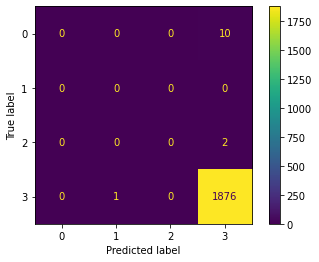

In [43]:
# Generate predictions with the best model
y_pred = rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
# In order for graphviz to work locally, you'll need to do the following:
# 1. run: `pip install graphviz`
# 2. Download Executable: https://graphviz.org/download/
    #2.1: Install the exe file
    #2.2: Add environment path variable - "C:\Program Files\Graphviz\bin" 

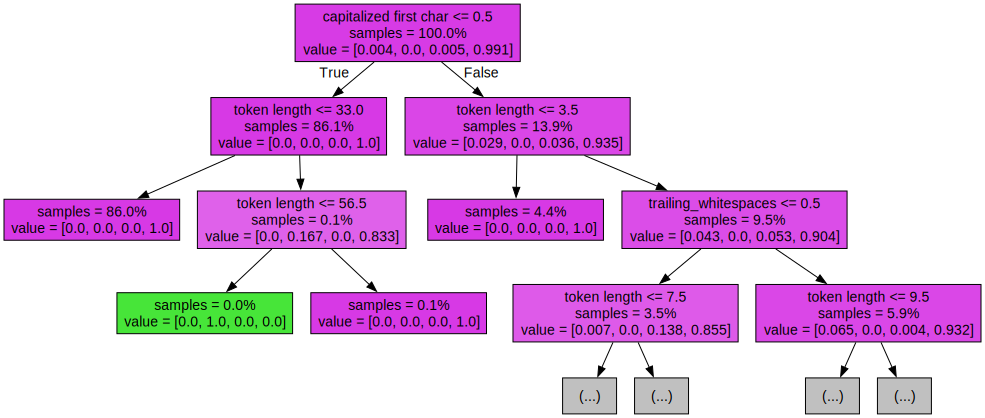

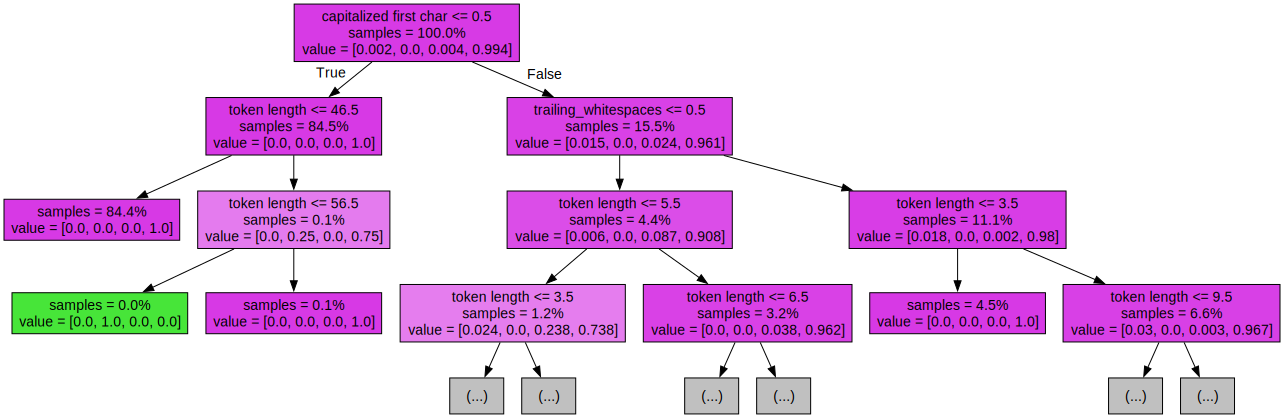

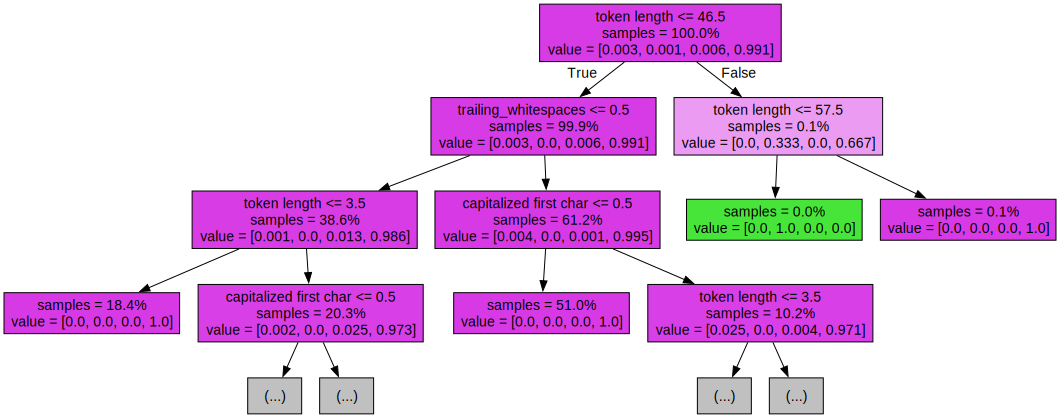

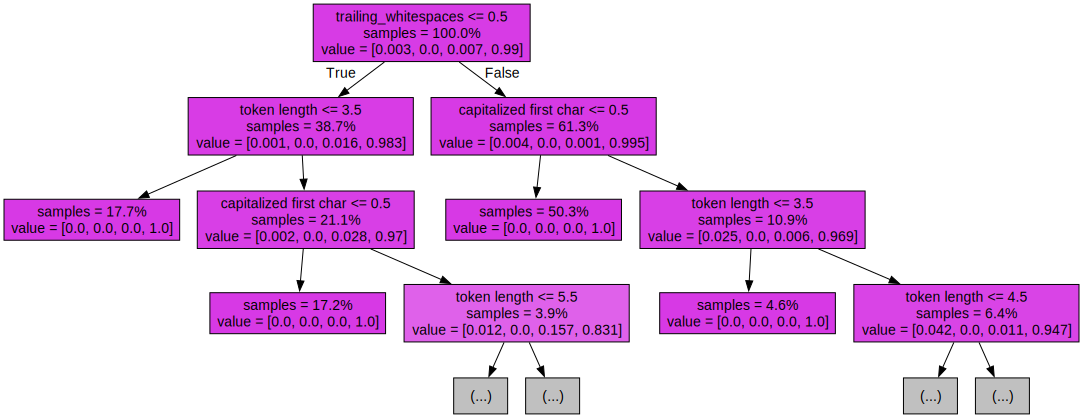

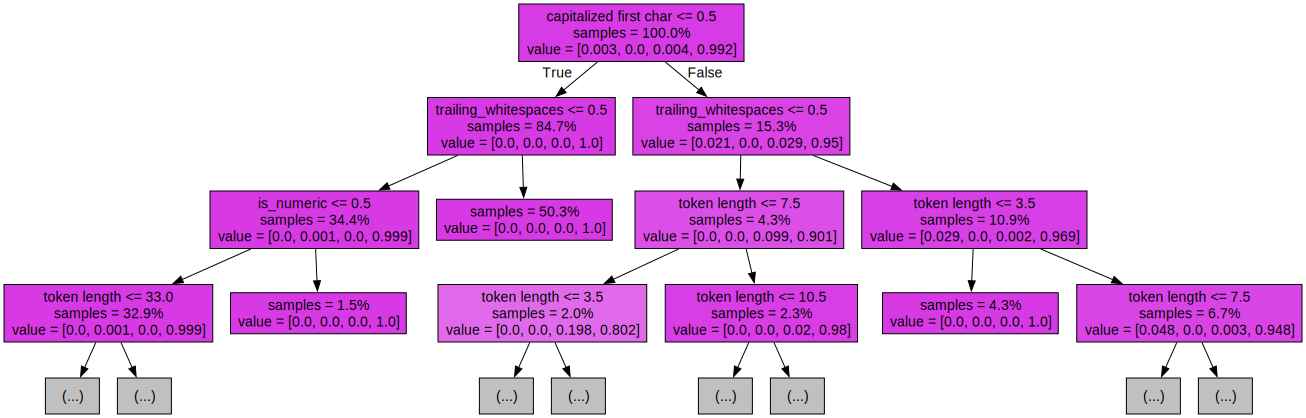

In [50]:
# Creating the Random forest graph for 5 decisions

for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)